In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Flatten, Conv1D, MaxPooling1D, Activation, concatenate, BatchNormalization, Add
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.regularizers import l2

from keras.optimizers import Adam,RMSprop
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
seed=42

In [2]:
df=pd.read_csv('features_flight_heli.csv')
df.dropna(inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6424 entries, 0 to 6423
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fname        6424 non-null   object 
 1   alt_max      6424 non-null   float64
 2   vert_acc     6424 non-null   float64
 3   horiz_speed  6424 non-null   float64
 4   dist         6424 non-null   float64
 5   is_maneuver  6424 non-null   float64
dtypes: float64(5), object(1)
memory usage: 351.3+ KB


In [3]:
df.drop(['fname'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6424 entries, 0 to 6423
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   alt_max      6424 non-null   float64
 1   vert_acc     6424 non-null   float64
 2   horiz_speed  6424 non-null   float64
 3   dist         6424 non-null   float64
 4   is_maneuver  6424 non-null   float64
dtypes: float64(5)
memory usage: 301.1 KB


In [4]:
df['is_maneuver'].value_counts()

1.0    4787
0.0    1637
Name: is_maneuver, dtype: int64

In [5]:
Y = df['is_maneuver']
X = df.drop(['is_maneuver'], axis=1)

print(X.shape)
print(Y.shape)

(6424, 4)
(6424,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=seed)

In [7]:
X_train = np.array(X_train)
X_test=np.array(X_test)

In [8]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [9]:
inputs = Input(shape=(X_train.shape[1],))
x = Dense(512)(inputs)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(256)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

residual = x

x = Dense(128)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(64)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(32)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

residual = Dense(32)(residual)
x = Add()([x, residual])
x = Activation('relu')(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_reduction])

Epoch 1/20
41/41 [==============================] - 5s 33ms/step - loss: 0.6753 - accuracy: 0.6801 - val_loss: 0.6953 - val_accuracy: 0.3307 - lr: 1.0000e-04
Epoch 2/20
41/41 [==============================] - 1s 18ms/step - loss: 0.5192 - accuracy: 0.7893 - val_loss: 0.6839 - val_accuracy: 0.3829 - lr: 1.0000e-04
Epoch 3/20
41/41 [==============================] - 1s 16ms/step - loss: 0.4885 - accuracy: 0.8122 - val_loss: 0.6594 - val_accuracy: 0.7829 - lr: 1.0000e-04
Epoch 4/20
41/41 [==============================] - 1s 15ms/step - loss: 0.4656 - accuracy: 0.8218 - val_loss: 0.6320 - val_accuracy: 0.8319 - lr: 1.0000e-04
Epoch 5/20
41/41 [==============================] - 1s 16ms/step - loss: 0.4641 - accuracy: 0.8260 - val_loss: 0.6014 - val_accuracy: 0.8475 - lr: 1.0000e-04
Epoch 6/20
41/41 [==============================] - 1s 16ms/step - loss: 0.4533 - accuracy: 0.8233 - val_loss: 0.5719 - val_accuracy: 0.8506 - lr: 1.0000e-04
Epoch 7/20
41/41 [==============================] - 

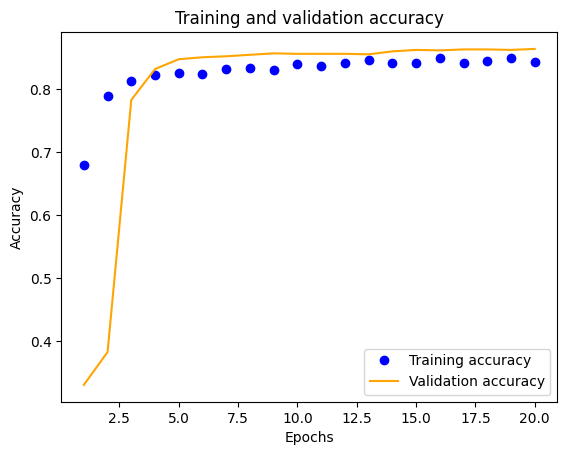

0.8638132214546204

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


np.max(val_acc)

In [13]:
inputs = Input(shape=(X_train.shape[1],))
x = Dense(512)(inputs)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

residual = x

x = Dense(128)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(64)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(32)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

residual = Dense(32)(residual)
x = Add()([x, residual])
x = Activation('relu')(x)

outputs = Dense(1, activation='sigmoid')(x)

model1 = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7)

# Train the model
history1 = model1.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_reduction])

Epoch 1/50
41/41 [==============================] - 2s 19ms/step - loss: 0.6766 - accuracy: 0.6244 - val_loss: 0.5906 - val_accuracy: 0.8591 - lr: 1.0000e-04
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.5565 - accuracy: 0.8142 - val_loss: 0.4906 - val_accuracy: 0.8553 - lr: 1.0000e-04
Epoch 3/50
41/41 [==============================] - 1s 13ms/step - loss: 0.4706 - accuracy: 0.8363 - val_loss: 0.4212 - val_accuracy: 0.8568 - lr: 1.0000e-04
Epoch 4/50
41/41 [==============================] - 1s 13ms/step - loss: 0.4265 - accuracy: 0.8465 - val_loss: 0.3947 - val_accuracy: 0.8553 - lr: 1.0000e-04
Epoch 5/50
41/41 [==============================] - 0s 12ms/step - loss: 0.4127 - accuracy: 0.8507 - val_loss: 0.3862 - val_accuracy: 0.8576 - lr: 1.0000e-04
Epoch 6/50
41/41 [==============================] - 1s 13ms/step - loss: 0.4055 - accuracy: 0.8513 - val_loss: 0.3811 - val_accuracy: 0.8576 - lr: 1.0000e-04
Epoch 7/50
41/41 [==============================] - 

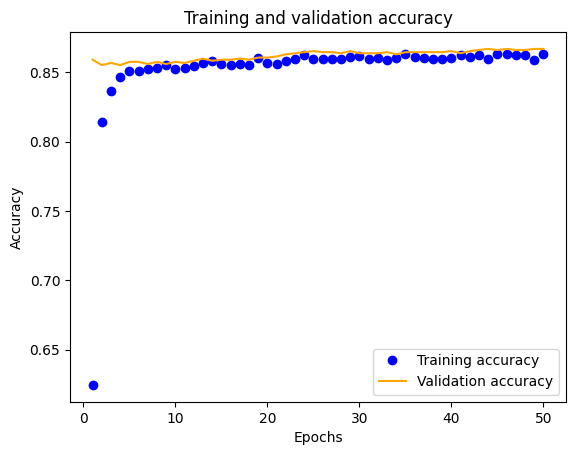

0.8669260740280151

In [14]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


np.max(val_acc)

In [19]:
inputs = Input(shape=(X_train.shape[1],))
x = Dense(512, activation='relu')(inputs)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

residual = x

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)

residual = Dense(32, activation='relu')(residual)
x = Add()([x, residual])
x = Activation('relu')(x)

outputs = Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Experiment with learning rate
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7)

# Train the model
history2 = model2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_reduction])

Epoch 1/50
81/81 [==============================] - 4s 23ms/step - loss: 0.4298 - accuracy: 0.8311 - val_loss: 0.3589 - val_accuracy: 0.8591 - lr: 0.0010
Epoch 2/50
81/81 [==============================] - 1s 17ms/step - loss: 0.3787 - accuracy: 0.8558 - val_loss: 0.3549 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 3/50
81/81 [==============================] - 1s 10ms/step - loss: 0.3708 - accuracy: 0.8579 - val_loss: 0.3465 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 4/50
81/81 [==============================] - 1s 10ms/step - loss: 0.3697 - accuracy: 0.8609 - val_loss: 0.3435 - val_accuracy: 0.8669 - lr: 0.0010
Epoch 5/50
81/81 [==============================] - 1s 9ms/step - loss: 0.3640 - accuracy: 0.8609 - val_loss: 0.3395 - val_accuracy: 0.8669 - lr: 0.0010
Epoch 6/50
81/81 [==============================] - 1s 9ms/step - loss: 0.3584 - accuracy: 0.8611 - val_loss: 0.3361 - val_accuracy: 0.8693 - lr: 0.0010
Epoch 7/50
81/81 [==============================] - 1s 10ms/step - loss: 0.353

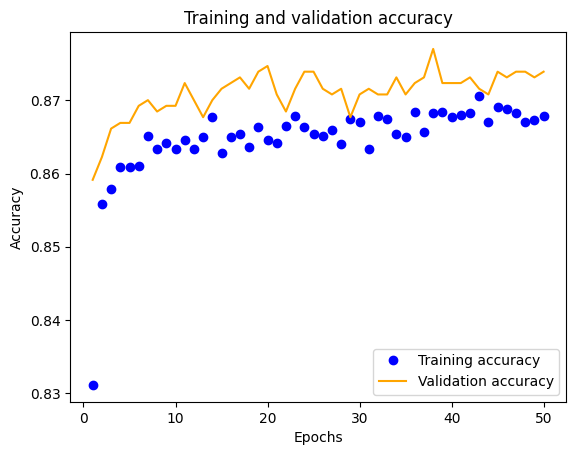

0.877042829990387

In [20]:

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


np.max(val_acc)

In [21]:
inputs = Input(shape=(X_train.shape[1],))

# Define the architecture
x = Dense(512, activation='relu')(inputs)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

residual = x

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)

residual = Dense(32, activation='relu')(residual)
x = Add()([x, residual])
x = Activation('relu')(x)

# Output layer
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model3 = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7)

# Train the model
history3 = model3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_reduction])

Epoch 1/50
81/81 [==============================] - 2s 11ms/step - loss: 0.4311 - accuracy: 0.8352 - val_loss: 0.3668 - val_accuracy: 0.8545 - lr: 0.0010
Epoch 2/50
81/81 [==============================] - 1s 9ms/step - loss: 0.3816 - accuracy: 0.8537 - val_loss: 0.3564 - val_accuracy: 0.8615 - lr: 0.0010
Epoch 3/50
81/81 [==============================] - 1s 10ms/step - loss: 0.3742 - accuracy: 0.8572 - val_loss: 0.3510 - val_accuracy: 0.8615 - lr: 0.0010
Epoch 4/50
81/81 [==============================] - 1s 11ms/step - loss: 0.3698 - accuracy: 0.8609 - val_loss: 0.3451 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 5/50
81/81 [==============================] - 1s 10ms/step - loss: 0.3675 - accuracy: 0.8597 - val_loss: 0.3413 - val_accuracy: 0.8677 - lr: 0.0010
Epoch 6/50
81/81 [==============================] - 1s 9ms/step - loss: 0.3606 - accuracy: 0.8609 - val_loss: 0.3406 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 7/50
81/81 [==============================] - 1s 9ms/step - loss: 0.3567

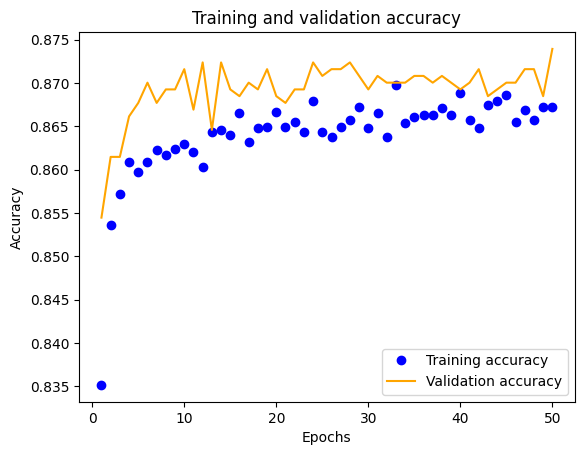

0.8739299774169922

In [22]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


np.max(val_acc)

In [29]:
inputs = Input(shape=(X_train.shape[1],))
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(inputs)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

residual = x

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

residual = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(residual)
x = Add()([x, residual])
x = Activation('relu')(x)

outputs = Dense(1, activation='sigmoid')(x)

model4 = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7)

# Train the model
history4 = model4.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_reduction])

Epoch 1/50
81/81 [==============================] - 2s 12ms/step - loss: 1.2765 - accuracy: 0.7570 - val_loss: 1.1519 - val_accuracy: 0.8521 - lr: 1.0000e-04
Epoch 2/50
81/81 [==============================] - 1s 9ms/step - loss: 1.1116 - accuracy: 0.8303 - val_loss: 1.0531 - val_accuracy: 0.8521 - lr: 1.0000e-04
Epoch 3/50
81/81 [==============================] - 1s 11ms/step - loss: 1.0486 - accuracy: 0.8465 - val_loss: 1.0099 - val_accuracy: 0.8529 - lr: 1.0000e-04
Epoch 4/50
81/81 [==============================] - 1s 12ms/step - loss: 1.0038 - accuracy: 0.8496 - val_loss: 0.9705 - val_accuracy: 0.8521 - lr: 1.0000e-04
Epoch 5/50
81/81 [==============================] - 1s 11ms/step - loss: 0.9729 - accuracy: 0.8523 - val_loss: 0.9383 - val_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 6/50
81/81 [==============================] - 1s 10ms/step - loss: 0.9435 - accuracy: 0.8517 - val_loss: 0.9077 - val_accuracy: 0.8568 - lr: 1.0000e-04
Epoch 7/50
81/81 [==============================] - 1

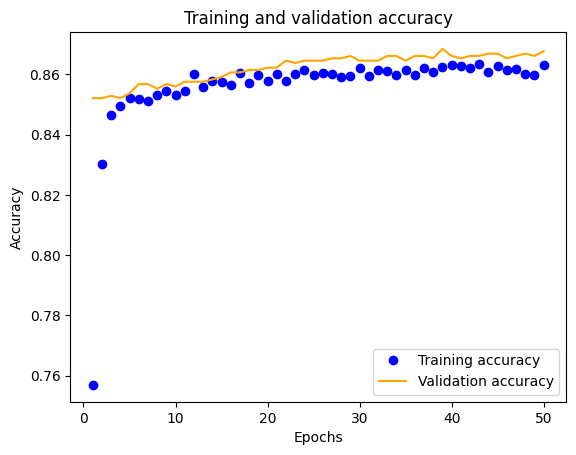

0.8684824705123901

In [30]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


np.max(val_acc)

In [33]:
inputs = Input(shape=(X_train.shape[1],))

# Initial dense layers
x = Dense(256)(inputs)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Residual connection starts here
residual = x

x = Dense(64)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(32)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(16)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Residual connection
residual = Dense(16)(residual)
x = Add()([x, residual])
x = Activation('relu')(x)

# Output layer
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model5 = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model5.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history5 = model5.fit(X_train, y_train, epochs=80, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/80
65/65 [==============================] - 7s 19ms/step - loss: 0.5909 - accuracy: 0.7755 - val_loss: 0.6106 - val_accuracy: 0.7305
Epoch 2/80
65/65 [==============================] - 1s 12ms/step - loss: 0.4852 - accuracy: 0.8251 - val_loss: 0.5586 - val_accuracy: 0.7305
Epoch 3/80
65/65 [==============================] - 1s 10ms/step - loss: 0.4751 - accuracy: 0.8273 - val_loss: 0.5189 - val_accuracy: 0.7305
Epoch 4/80
65/65 [==============================] - 1s 8ms/step - loss: 0.4425 - accuracy: 0.8363 - val_loss: 0.5012 - val_accuracy: 0.7335
Epoch 5/80
65/65 [==============================] - 1s 8ms/step - loss: 0.4218 - accuracy: 0.8360 - val_loss: 0.4701 - val_accuracy: 0.7909
Epoch 6/80
65/65 [==============================] - 1s 8ms/step - loss: 0.4231 - accuracy: 0.8392 - val_loss: 0.4244 - val_accuracy: 0.8307
Epoch 7/80
65/65 [==============================] - 1s 8ms/step - loss: 0.4018 - accuracy: 0.8414 - val_loss: 0.4063 - val_accuracy: 0.8434
Epoch 8/80
65/65 

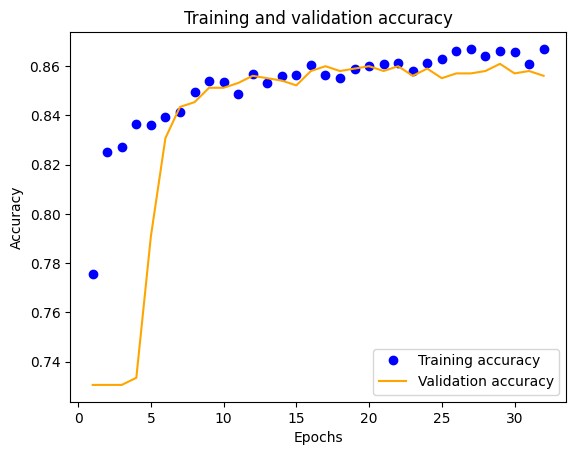

0.8608949184417725

In [34]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


np.max(val_acc)

In [35]:
inputs = Input(shape=(X_train.shape[1],))

# Define the architecture
x = Dense(512, activation='relu')(inputs)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

residual = x

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)

residual = Dense(32, activation='relu')(residual)
x = Add()([x, residual])
x = Activation('relu')(x)

# Output layer
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model6 = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model6.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7)

# Train the model
history6 = model6.fit(X_train, y_train, epochs=80, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_reduction])

Epoch 1/80
41/41 [==============================] - 2s 21ms/step - loss: 0.4514 - accuracy: 0.8266 - val_loss: 0.3752 - val_accuracy: 0.8591 - lr: 0.0010
Epoch 2/80
41/41 [==============================] - 1s 13ms/step - loss: 0.3829 - accuracy: 0.8543 - val_loss: 0.3570 - val_accuracy: 0.8599 - lr: 0.0010
Epoch 3/80
41/41 [==============================] - 1s 17ms/step - loss: 0.3770 - accuracy: 0.8587 - val_loss: 0.3530 - val_accuracy: 0.8607 - lr: 0.0010
Epoch 4/80
41/41 [==============================] - 1s 22ms/step - loss: 0.3690 - accuracy: 0.8595 - val_loss: 0.3491 - val_accuracy: 0.8654 - lr: 0.0010
Epoch 5/80
41/41 [==============================] - 1s 19ms/step - loss: 0.3612 - accuracy: 0.8624 - val_loss: 0.3442 - val_accuracy: 0.8669 - lr: 0.0010
Epoch 6/80
41/41 [==============================] - 1s 21ms/step - loss: 0.3667 - accuracy: 0.8615 - val_loss: 0.3438 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 7/80
41/41 [==============================] - 1s 17ms/step - loss: 0.3

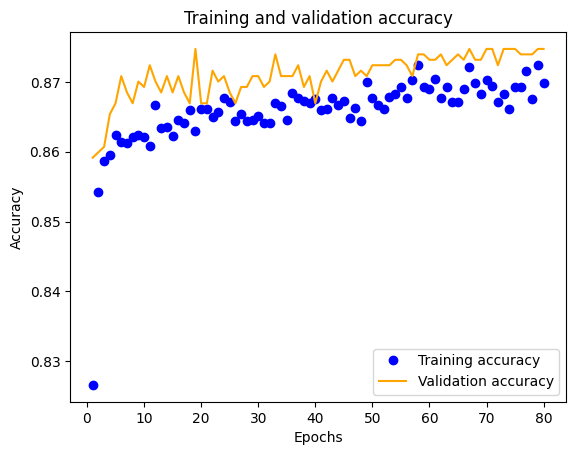

0.8747081756591797

In [36]:
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


np.max(val_acc)

In [37]:
inputs = Input(shape=(X_train.shape[1],))

# Define the architecture
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(inputs)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

residual = x

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

residual = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(residual)
x = Add()([x, residual])
x = Activation('relu')(x)

# Output layer
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model7 = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model7.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7)

# Train the model
history7 = model7.fit(X_train, y_train, epochs=80, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_reduction])

Epoch 1/80
41/41 [==============================] - 2s 21ms/step - loss: 1.0859 - accuracy: 0.8062 - val_loss: 0.9018 - val_accuracy: 0.8553 - lr: 0.0010
Epoch 2/80
41/41 [==============================] - 1s 14ms/step - loss: 0.8449 - accuracy: 0.8560 - val_loss: 0.7466 - val_accuracy: 0.8560 - lr: 0.0010
Epoch 3/80
41/41 [==============================] - 1s 13ms/step - loss: 0.7184 - accuracy: 0.8541 - val_loss: 0.6504 - val_accuracy: 0.8630 - lr: 0.0010
Epoch 4/80
41/41 [==============================] - 1s 19ms/step - loss: 0.6302 - accuracy: 0.8589 - val_loss: 0.5812 - val_accuracy: 0.8599 - lr: 0.0010
Epoch 5/80
41/41 [==============================] - 1s 21ms/step - loss: 0.5762 - accuracy: 0.8556 - val_loss: 0.5337 - val_accuracy: 0.8638 - lr: 0.0010
Epoch 6/80
41/41 [==============================] - 1s 31ms/step - loss: 0.5261 - accuracy: 0.8616 - val_loss: 0.4890 - val_accuracy: 0.8654 - lr: 0.0010
Epoch 7/80
41/41 [==============================] - 1s 30ms/step - loss: 0.5

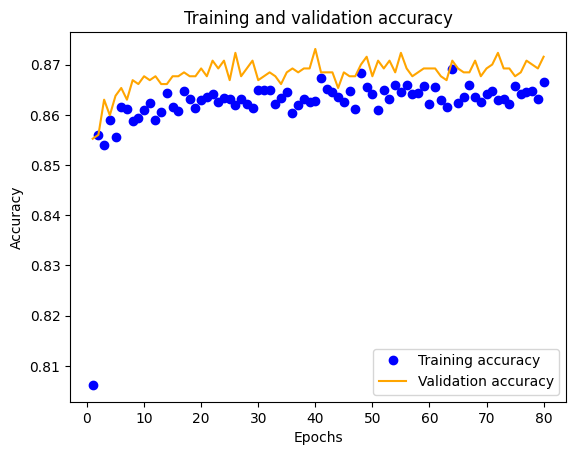

0.8731517791748047

In [38]:
acc = history7.history['accuracy']
val_acc = history7.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


np.max(val_acc)